In [1]:
import kwant
import matplotlib.pyplot as plt
import types
import numpy as np
import math
import tinyarray

def eV2au(energy):
    return energy*0.03674932587122423
def au2eV(energy):
    return energy/0.03674932587122423
def nm2au(length):
    return length*18.89726133921252
def au2nm(length):
    return length/18.89726133921252
def T2au(B):
    return B*4.254382E-6
def au2T(B):
    return B/4.254382E-6
pi=3.14159265359

mu_b = 0.5
sigma0 = tinyarray.array([[1, 0], [0, 1]])
sigmax = tinyarray.array([[0, 1], [1, 0]])
sigmay = tinyarray.array([[0, -1j], [1j, 0]])
sigmaz = tinyarray.array([[1, 0], [0, -1]])
sigma_law = tinyarray.array([[1, 0], [0, 2]])


In [2]:
nw = types.SimpleNamespace(\
                     dx=nm2au(5),
                     m=0.014,
                     W=nm2au(101), #given in [nm]
                     L=nm2au(800),
                     Bx=T2au(0),
                     By=T2au(0),
                     Bz=T2au(0),
                     g = -50,
                     energy=eV2au(1.8e-3),
                     alfa_so=nm2au(eV2au(50.0e-3))
                        )

In [3]:
def make_system(nw):
    W = nw.W
    L = nw.L
    dx = nw.dx
    m = nw.m    
    Bx = nw.Bx
    By = nw.By
    Bz = nw.Bz
    g = nw.g
    alfa_so=nw.alfa_so
    t=1.0/(2.0*m*dx*dx)
    
    
    def onsite(sitei):
        x,y=sitei.pos
        t=1.0/(2.0*m*dx*dx)
        return 4*t*sigma0 + 0.5*g*mu_b*(Bx*sigmax + By*sigmay + Bz*sigmaz)
        
        
    def sys_shape(pos):
        x,y=pos
        iss=True
        if (x >= 0 and x <= L and  y >= 0 and y <= W):
            iss=True
        else:
            iss=False
        return iss        
        
    def hopping_x(sitei, sitej):
        xi,yi=sitei.pos
        xj,yj=sitej.pos
        t=1.0/(2.0*m*dx*dx)              
        t_so=1.0/(2.0*dx)
        
        #współczynnik alfa 
        if (xi >= L/6 and xi <= 5*L/6):                                   
            alfa = alfa_so  
        else:
            alfa = 0
        
        return -t*sigma0 + 1j*t_so*alfa*sigmay
        
    
    def hopping_y(sitei, sitej):
        xi,yi=sitei.pos
        xj,yj=sitej.pos
        t=1.0/(2.0*m*dx*dx)            
        t_so=1.0/(2.0*dx)
        
        #współczynnik alfa 
        if (xi >= L/6 and xi <= 5*L/6):                                    
            alfa = alfa_so  
        else:
            alfa = 0
        
        return -t*sigma0 - 1j*t_so*alfa*sigmax
        
    sys = kwant.Builder()  
    lat=kwant.lattice.square(dx, norbs=2)
    sys[lat.shape(sys_shape, (0, 0))] = onsite
    sys[kwant.builder.HoppingKind((-1,0), lat, lat)] = hopping_x
    sys[kwant.builder.HoppingKind((0,-1), lat, lat)] = hopping_y
 
    
    def lead_shape(pos):
        x,y=pos
        iss=True
        if (y >= 0 and y <= W):
            iss=True
        else:
            iss=False
        return iss    
    
    #conservation_law=sigma_law - w leadach rozdzielnie spin up i spin down
    left_lead=kwant.Builder(kwant.TranslationalSymmetry((-dx, 0)),conservation_law=sigma_law)
    lat=kwant.lattice.square(dx, norbs=2)       
    left_lead[lat.shape(lead_shape, (0, 0))] = onsite
    left_lead[kwant.builder.HoppingKind((-1,0), lat, lat)] = hopping_x
    left_lead[kwant.builder.HoppingKind((0,-1), lat, lat)] = hopping_y
    sys.attach_lead(left_lead)
    
    right_lead=kwant.Builder(kwant.TranslationalSymmetry((dx, 0)),conservation_law=sigma_law)
    lat=kwant.lattice.square(dx, norbs=2)       
    right_lead[lat.shape(lead_shape, (L, 0))] = onsite
    right_lead[kwant.builder.HoppingKind((-1,0), lat, lat)] = hopping_x
    right_lead[kwant.builder.HoppingKind((0,-1), lat, lat)] = hopping_y
    sys.attach_lead(right_lead)
    
    sys = sys.finalized()
    return sys


def make_lead(nw):
    W = nw.W
    L = nw.L
    dx = nw.dx
    m = nw.m    
    Bx = nw.Bx
    By = nw.By
    Bz = nw.Bz
    g = nw.g
    t=1.0/(2.0*m*dx*dx)
    alfa_so=nw.alfa_so


    def onsite(sitei):
        x,y=sitei.pos
        t=1.0/(2.0*m*dx*dx)
        return 4*t*sigma0 + 0.5*g*mu_b*(Bx*sigmax + By*sigmay + Bz*sigmaz)

    def hopping_x(sitei, sitej):
        xi,yi=sitei.pos
        xj,yj=sitej.pos
        t=1.0/(2.0*m*dx*dx)               
        t_so=1.0/(2.0*dx)
        
        return -t*sigma0 + 1j*t_so*alfa_so*sigmay
        
    def hopping_y(sitei, sitej):
        xi,yi=sitei.pos
        xj,yj=sitej.pos
        t=1.0/(2.0*m*dx*dx)              
        t_so=1.0/(2.0*dx)
        
        return -t*sigma0 - 1j*t_so*alfa_so*sigmax
        
    def lead_shape(pos):
        x,y=pos
        iss=True
        if (y >= 0 and y <= W):
            iss=True
        else:
            iss=False
        return iss
    
    lead=kwant.Builder(kwant.TranslationalSymmetry((-dx, 0))) 
    lat=kwant.lattice.square(dx, norbs=2)       
    lead[lat.shape(lead_shape, (0, 0))] = onsite
    lead[kwant.builder.HoppingKind((-1,0), lat, lat)] = hopping_x
    lead[kwant.builder.HoppingKind((0,-1), lat, lat)] = hopping_y
    lead = lead.finalized()
    return lead

In [4]:
def disperssion(nw, nr_lead, k_max, nk):
    dx=nw.dx
    sys=make_system(nw)
    momenta = np.linspace(-k_max*dx,k_max*dx,nk)
    bands=kwant.physics.Bands(sys.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta/dx)*nm2au(1.0), energies

def calculate_transmision(nw):
    energy=nw.energy
    sys=make_system(nw)
    smatrix = kwant.smatrix(sys, energy)
    t=smatrix.transmission(1,0)
    return t

def calculate_transmision_spin(nw):
    energy=nw.energy
    sys=make_system(nw)
    smatrix = kwant.smatrix(sys, energy)
    
    tup_up=smatrix.transmission((1,0), (0,0)) # lead 0, orbital 0 -> lead 1, orbital 0(up)
    tup_down=smatrix.transmission((1,1), (0,0))
    tdown_up=smatrix.transmission((1,0), (0,1))
    tdown_down=smatrix.transmission((1,1), (0,1))  
    
    return tup_up, tup_down, tdown_up, tdown_down

def calculate_transmision_alfa_so(nw, alfa_max, alfa_points = 100):
    trans=[]
    alfa_tab=np.linspace(0,alfa_max,alfa_points)
    for alfa in alfa_tab:
        nw.alfa_so=nm2au(eV2au(alfa))
        trans.append(calculate_transmision_spin(nw))
    
    return alfa_tab, np.array(trans)

def pasma(nw, k_max, nk, k_range, e_range):
    k_max=au2nm(k_max)
    dx=nw.dx
    lead=make_lead(nw)
    band=kwant.physics.Bands(lead)
    momenta = np.linspace(-k_max*dx, k_max*dx, nk)
    energies = [band(k) for k in momenta]
    energies_meV = 1000*au2eV(np.asarray(energies))
    plt.figure(figsize=(10,6)) 
    plt.plot(nm2au(momenta/dx), energies_meV,'k-')
    plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xlim((-k_range,k_range))
    plt.xlim((-0.12,0.12))
    #plt.ylim((0,e_range*1000))
    plt.ylim((0,30))
    plt.xlabel("$k_{x}$ [1/nm]",fontsize=18)
    plt.ylabel("E [meV]",fontsize=18)
    plt.grid(axis='both')
    #plt.savefig('W201_TS_pasma_alfa0.pdf', format='pdf',bbox_inches="tight")
    
    plt.show()

# RESULTS

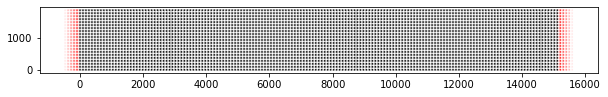

In [5]:
sys=make_system(nw)
kwant.plot(sys, site_color=lambda site: abs(sys.hamiltonian(site,site))[0,0], fig_size=(10,5), colorbar=False, show=False, num_lead_cells=5);

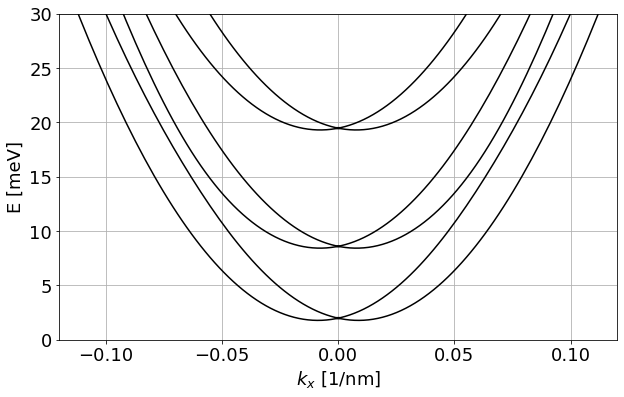

In [6]:
nw.alfa_so=nm2au(eV2au(50e-3))
pasma(nw,0.5,500,0.5,0.1)

In [7]:
#transmision (spin) w funkcji alfa_so
nw.energy=eV2au(5e-3)
alfa_values, trans_alfa = calculate_transmision_alfa_so(nw,50e-3,30)

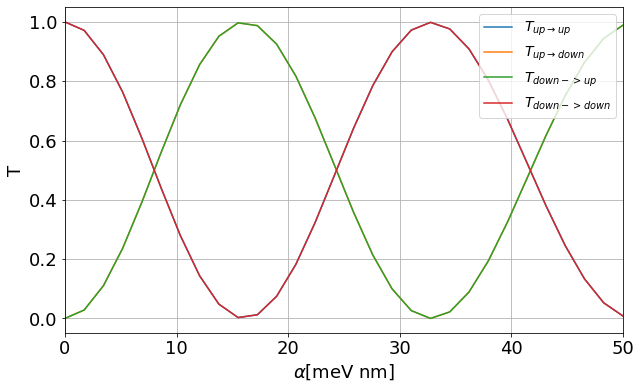

In [8]:
plt.figure(figsize=(10,6)) 
plt.plot(1000*alfa_values, trans_alfa[:,0],'-',label="$T_{up\\rightarrow up}$")
plt.plot(1000*alfa_values, trans_alfa[:,1],'-',label="$T_{up\\rightarrow down}$")
plt.plot(1000*alfa_values, trans_alfa[:,2],'-',label="$T_{down->up}$")
plt.plot(1000*alfa_values, trans_alfa[:,3],'-',label="$T_{down->down}$")
plt.xlabel("$\\alpha $[meV nm]",fontsize=18)  
plt.ylabel("T",fontsize=18)
plt.grid(axis='both')
plt.xlim((0,50))
plt.tick_params(axis='both', which='major', labelsize=18)  #, labelsize=18
plt.legend(prop={'size': 14}, loc='upper right')
#, bbox_to_anchor=(1.45, 1.05)
plt.show()

/opt/miniconda3/envs/env-tkwant/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: The plotted data contains 0.18% of values overflowing upper limit 78.0651 


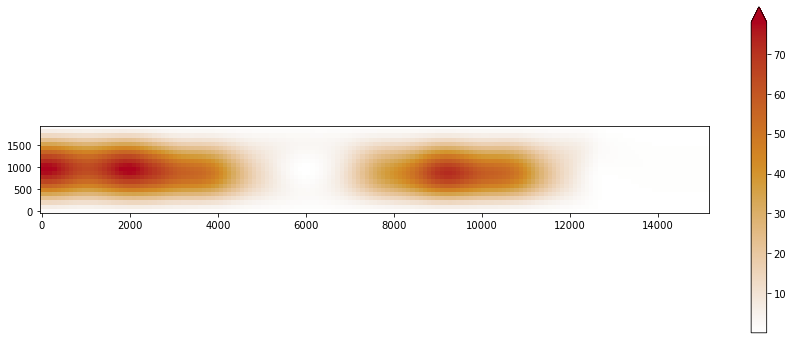

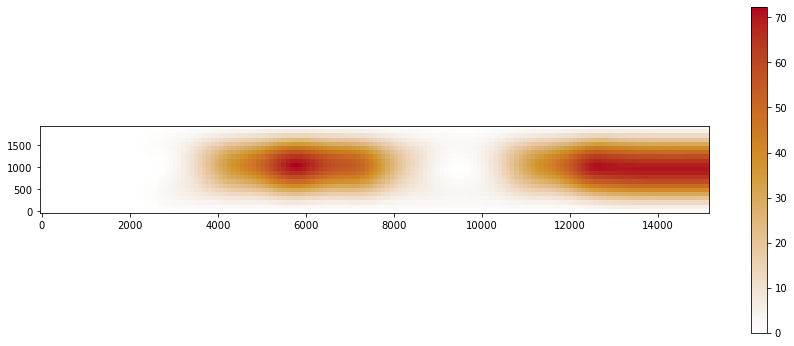

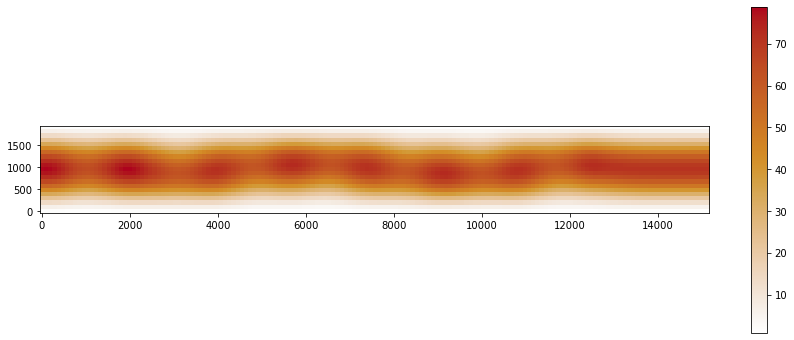

In [9]:
#rozklad elektronow (gęstość elektronowa)
nw.energy=eV2au(5e-3)
nw.alfa_so=nm2au(eV2au(50e-3))

sys = make_system(nw)
wave_f=kwant.wave_function(sys,nw.energy)(0)

density_up=tinyarray.array([[1,0],\
                            [0,0]])

density_down=tinyarray.array([[0,0],\
                            [0,1]])

density_both=tinyarray.array([[1,0],\
                            [0,1]])


density_up_op=kwant.operator.Density(sys,density_up) 
density_down_op=kwant.operator.Density(sys,density_down)
density_both_op=kwant.operator.Density(sys,density_both)

density_up_map=density_up_op(wave_f[0])
density_down_map=density_down_op(wave_f[0])
density_both_map=density_both_op(wave_f[0])

kwant.plotter.map(sys, density_up_map, fig_size = (15,6)); # spin up
kwant.plotter.map(sys, density_down_map, fig_size = (15,6)); # spin down
kwant.plotter.map(sys, density_both_map, fig_size = (15,6)); # spin up+down

/opt/miniconda3/envs/env-tkwant/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: The plotted data contains 0.44% of values overflowing upper limit 65.8739 
  


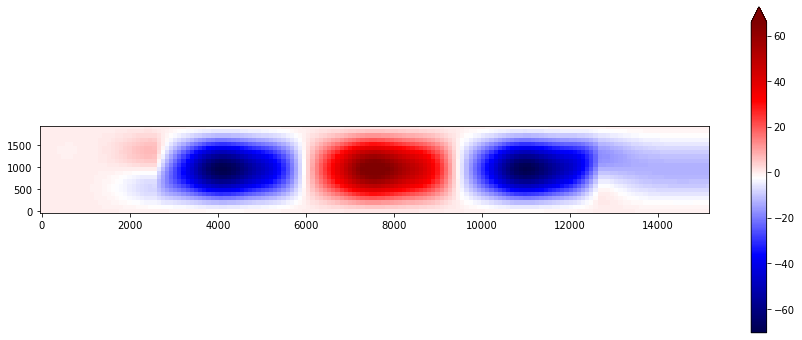

/opt/miniconda3/envs/env-tkwant/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: The plotted data contains 0.30% of values overflowing upper limit 22.7302 
  from ipykernel import kernelapp as app


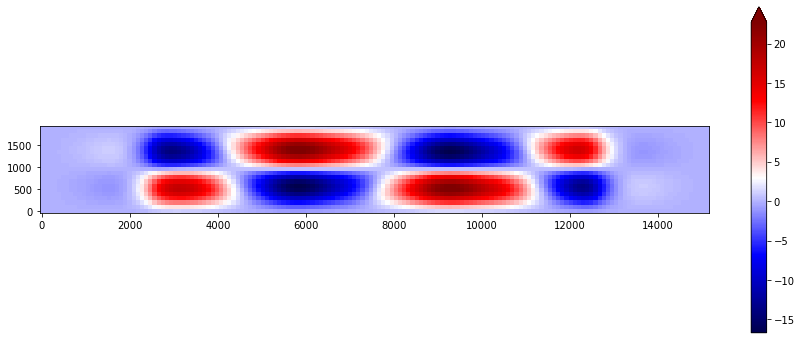

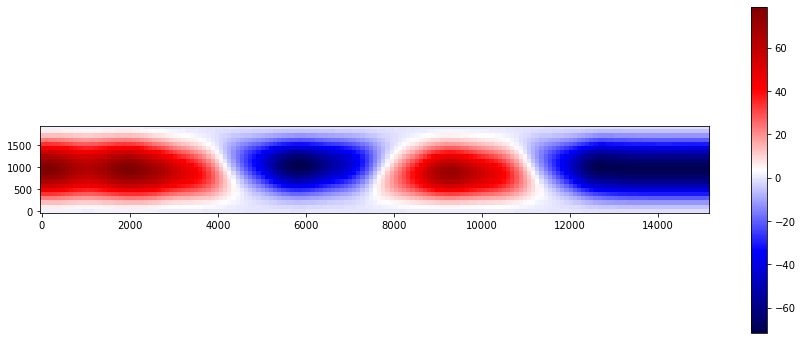

In [10]:
#spin density

sys = make_system(nw)
wave_f = kwant.wave_function(sys,nw.energy)(0)

spin_density_x=kwant.operator.Density(sys,sigmax)
spin_density_y=kwant.operator.Density(sys,sigmay)
spin_density_z=kwant.operator.Density(sys,sigmaz)

spin_density_x_map=spin_density_x(wave_f[0])
spin_density_y_map=spin_density_y(wave_f[0])
spin_density_z_map=spin_density_z(wave_f[0])

kwant.plotter.map(sys, spin_density_x_map, fig_size = (15,6), cmap='seismic'); # spin x
kwant.plotter.map(sys, spin_density_y_map, fig_size = (15,6), cmap='seismic'); # spin y
kwant.plotter.map(sys, spin_density_z_map, fig_size = (15,6), cmap='seismic'); # spin z
